# Anomaly detection with STL and Hampel filter preprocessing 

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
from sktime.transformations.series.outlier_detection import HampelFilter
from statsmodels.tsa.seasonal import STL

In [2]:
def plot_with_thresholds(df):
    anoms = df.loc[df["anom"], "latency"]
    fig = plt.figure(figsize=(12, 2))
    fig.suptitle("Latency")
    plt.plot(df["latency"])
    plt.plot(df["upper"], "r--")
    plt.scatter(x=anoms.index, y=anoms, color="r")
    plt.show()

## Raw time series data 

In [3]:
latency = [
    120.0, 102.0, 131.2, 103.8, 99.7, 98.2, 143.2,
    118.9, 101.5, 103.0, 97.3, 102.3, 96.4, 139.6,
    123.0, 102.0, 101.2, 102.8, 101.9, 98.2, 143.2,
    121.1, 98.0, 117.0, 102.4, 103.1, 100.8, 139.6,
    117.5, 102.2, 98.2, 103.1, 99.4, 98.2, 163.2,
    120.0, 102.0, 101.2, 103.6, 100.9, 98.2, 143.2,
    123.2, 135.6, 103.0, 101.4, 102.2, 100.3, 139.6,
    121.9, 98.1, 103.0, 102.1, 103.7, 102.4, 139.6,
    119.8, 93.0, 101.2, 99.4, 108.5, 98.3, 139.6,
    123.3, 102.2, 98.2, 103.1, 99.4, 98.2, 153.2,
    117.0, 102.0, 101.2, 103.8, 101.9, 98.2, 143.2,
]

In [4]:
df = pd.DataFrame(
    {"latency": latency},
    index=pd.date_range("2022-01-01", periods=len(latency), freq="D")
)

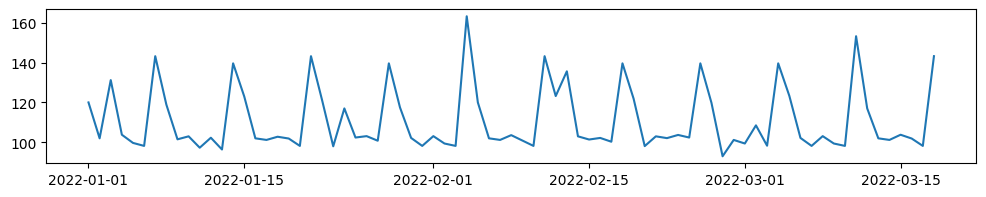

In [5]:
fig = plt.figure(figsize=(12, 2))
plt.plot(df["latency"])
plt.show()

## Preprocessing: STL decomposition 

In [6]:
stl = STL(df["latency"])
res = stl.fit()
df["resid"] = res.resid

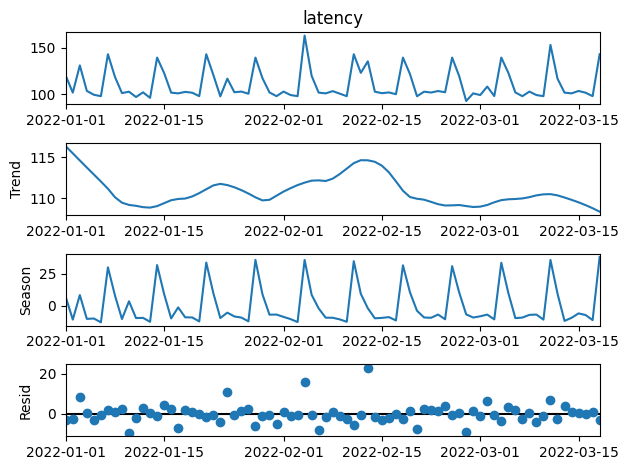

In [7]:
fig = res.plot()

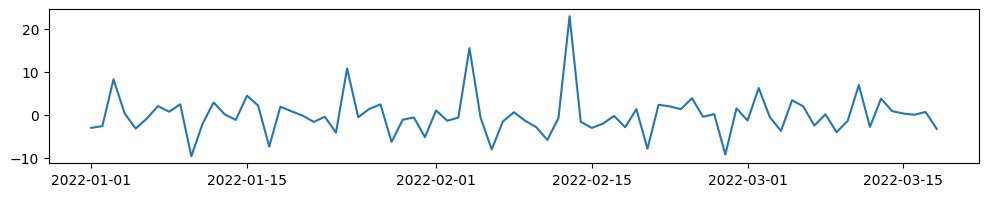

In [8]:
fig = plt.figure(figsize=(12, 2))
plt.plot(df["resid"])
plt.show()

## Preprocessing: Apply Hampel filter to remove outliers

In [9]:
filter = HampelFilter(window_length=5)
df["train"] = filter.fit_transform(df["resid"])

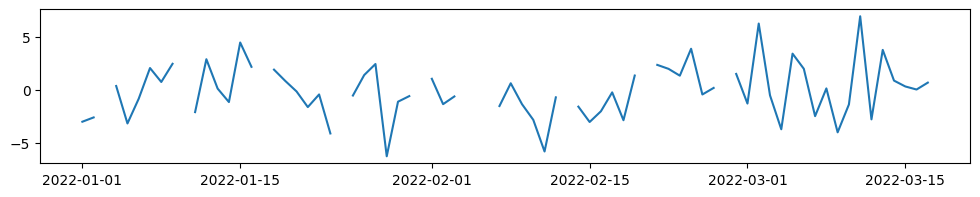

In [10]:
fig = plt.figure(figsize=(12, 2))
plt.plot(df["train"])
plt.show()

## Fit IQR threshold

Note: We aren't doing a train/test split here. Ideally we should do that to avoid overfitting.

In [11]:
q1 = df["train"].quantile(0.25)
q3 = df["train"].quantile(0.75)
iqr = q3 - q1
upper_resid = q3 + 1.5 * iqr

In [12]:
upper_resid

5.838746884259152

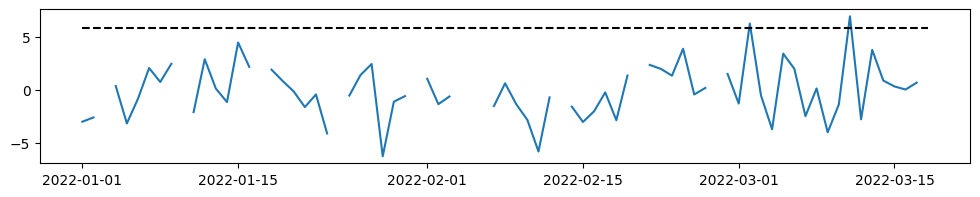

In [13]:
fig = plt.figure(figsize=(12, 2))
plt.plot(df["train"])
plt.plot([df.index[0], df.index[-1]], [upper_resid, upper_resid], "k--")
plt.show()

In [14]:
df["expected"] = res.trend + res.seasonal
df["upper"] = df["expected"] + upper_resid

## Apply threshold to full series

In [15]:
df["anom"] = df["resid"] >= upper_resid

## Plots 

In [16]:
anoms_resid = df.loc[df["anom"], "resid"]
anoms = df.loc[df["anom"], "latency"]

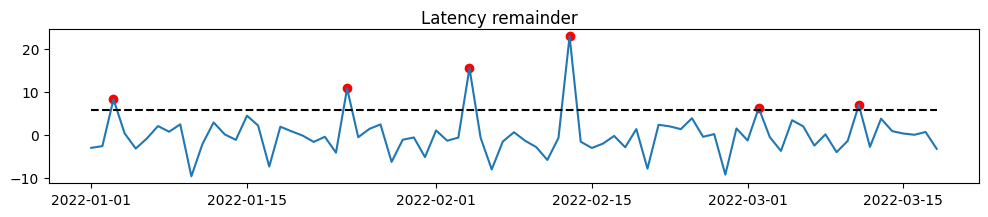

In [17]:
fig = plt.figure(figsize=(12, 2))
fig.suptitle("Latency remainder")
plt.plot(df["resid"])
plt.plot([df.index[0], df.index[-1]], [upper_resid, upper_resid], "k--")
plt.scatter(x=anoms_resid.index, y=anoms_resid, color="r")
plt.show()

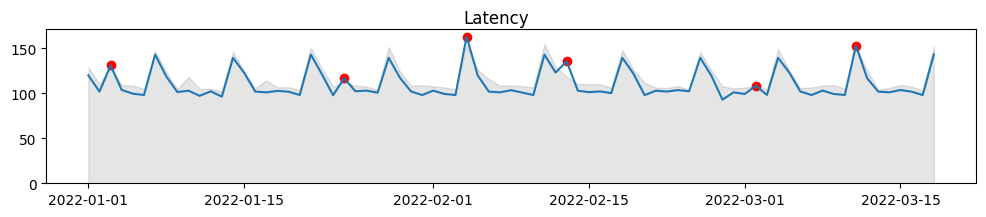

In [18]:
fig = plt.figure(figsize=(12, 2))
fig.suptitle("Latency")
plt.stackplot(df.index, df["upper"], color="k", alpha=0.1)
plt.plot(df["latency"], color="#1f77b4")
#plt.plot(df["expected"], "g--", alpha=0.5)
plt.scatter(x=anoms.index, y=anoms, color="r")
plt.show()